# Müller Brown I

Throughout the tutorials, we are going to demonstrate how to use totally accurate pathway simulator (TAPS). The tutorials aims for the user who wants to understands basic codes of the TAPS, presumably familiar with scientific Python programing like `numpy` and basic knowledge of chemical reaction pathway. Structre of TAPS begins with `Paths` class. `Paths` object contains other classes such as `Cartesian`, coordinate representation with kinetic energy calculatior, `Model`, potential and static energy calculator, `PathFinder`, pathway optimization algorithm and `Database` where calculated image data are stored. The reason for having this hierarchy is to efficietly link each class when they need each other. For example, static calculation such as gradient, potential or hessian requires the coordinate information and sometimes the data of previous calculation. When the calculation is conducted, `paths` object are handover to the `Model` object so that `Model` object can use the `Cartesian` or `Database` when they needed. Calculating kinetic energy works similarly. One might need only coordinate information but sometimes previous data can be necessary, for example one might wants to estimate the inertia of the atomic system with given only two angles. In that case, calcualtion of inertia is conducted using the data in the `Database` model. 

Müller Brown (MB) potential is great example for the start. MB is 2D model potential involves a few parameters used for test bench. This tutorial will construct a pathway on the MB potential and calculate the potential and forces at each image. Our mission here is to understand basic understanding of TAPS throught doing

1. Construction of a pathway
2. Potential calculation
3. Direct action optimization (DAO)

examples.

Initial and the last point of the Muller Brown potential are (-0.55822365, 1.44172582) and (0.6234994, 0.02803776) respectively. We are going to make simple linear pathway connecting to ends using numpy. 

In [1]:
import numpy as np
N = 300
x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)
coords = np.array([x, y])
coords.shape

(2, 300)

## Construction of a pathway

`Cartesian` contains `coords`, consecutive coordinate representation of images, `epoch`, time spend for transition between two states, and `unit`. `coords` should be $(D\times N)$ size array or $(3\times A \times N)$ array where $D$ is dimension, $N$ is the number of consecutive images (including both ends) and $A$ the number of atoms. Reason for $N$ is last index is because of the row-major ordring of `python`. 

Creating `Cartesian` object is simply put the `numpy` array into `coords` instance. 

In [2]:
from taps.coords import Cartesian

coords = Cartesian(coords=coords)
print(coords.shape, coords.D, coords.N, coords.epoch)

(2, 300) 2 300 3


<!---`Cartesian` is an array like object that can be treat as an `numpy` array.
 
 We are considering descrete example of a pathway, where atomic path are considered as a consecutive images. `coords` is coordinate having a shape $(D\times N)$ matrix where $D$ stands for dimension and $N$ stands for the number of consecutive images. Beginning.... 
-->

## Potential calculation 
MB potential is given by

 $$ V\left(x,y\right) = \sum_{\mu=1}^{4}{A_\mu e^{a_\mu \left(x-x_\mu^0\right)^2 + b_\mu \left(x-x_\mu^0\right) \left(y-y_\mu^0\right) + c_\mu\left(y-y_\mu^0\right)^2}}$$
 
`Model` object in TAPS has a few pre-defined toy model you can test your own algorithm. If you wants to know the parameters or info about that specific model, type "?" such as

In [3]:
from taps.models import MullerBrown
?MullerBrown
model = MullerBrown()
print(model.A)

[-2.   -1.   -1.7   0.15]


Init signature: MullerBrown(results=None, label=None, prj=None, _cache=None, unit='eV')
Docstring:     
Muller Brown Potential

.. math::

   \begin{equation}
   V\left(x,y\right) =
   \sum_{\mu=1}^{4}{A_\mu e^{a_\mu \left(x-x_\mu^0\right)^2
   + b_\mu \left(x-x_\mu^0\right) \left(y-y_\mu^0\right)
   + c_\mu\left(y-y_\mu^0\right)^2}}
   \end{equation}

* Initial position = (-0.55822365, 1.44172582)

* Final position = (0.6234994, 0.02803776)

Parameters
----------
A = np.array([-200, -100, -170, 15])
a = np.array([-1, -1, -6.5, 0.7])
b = np.array([0, 0, 11, 0.6])
c = np.array([-10, -10, -6.5, 0.7])
x0 = np.array([1, 0, -0.5, -1])
y0 = np.array([0, 0.5, 1.5, 1])
potential_unit = 'unitless'

Example
-------

>>> import numpy as np
>>> N = 300
>>> x = np.linspace(-0.55822365, 0.6234994, N)
>>> y = np.linspace(1.44172582, 0.02803776, N)
>>> paths.coords = np.array([x, y])
File:           ~/anaconda3/envs/py37/lib/python3.7/site-packages/taps/models/mullerbrown.py
Type:           type
Subcl

`Paths` class contains `cooords`, which for the class `Cartesian` and `model` where `Model` class are stored. To calculate the properties along the pathway, we need a wrapper that connects both `Model` and `Cartesian`. `Paths` is classs for that conviently move around each objects. Calculating potential, gradients and Hessian can be conducted by scripting

```python
paths.get_potential()
paths.get_gradients()
paths.get_hessian()
```

as a default, it calculates properties throughout whole consecutive images except both end . If one wants to calculate including both end, one can use the keyword `index`. Index takes the list of step numbers and calculates only on that step. 

In [4]:
from taps.paths import Paths

paths = Paths(coords=coords, model=model)
print(paths.get_potential(index=np.s_[5:10]))
print(paths.get_gradients(index=[1, 2, 3]).shape)

[-1.44794167 -1.43962909 -1.42985987 -1.41866061 -1.40606162]
(2, 3)


## Visualization

In a 2D model calcualtion case, calculation are assumed to be very light. Thus, visualization of the package try to show the properties not only along the pathway but also the potential energy surface around it. 
`Plotter` object visualize coordinate automatically with PES around it. It is not critical for the reaction calculation but it gives you insight around it. By default, 3D pathway like atomic system doesn't do PES map calcualtion. It only gives you the potential, kinetic and total energy along the pathway. Viewing the `paths` is simply,

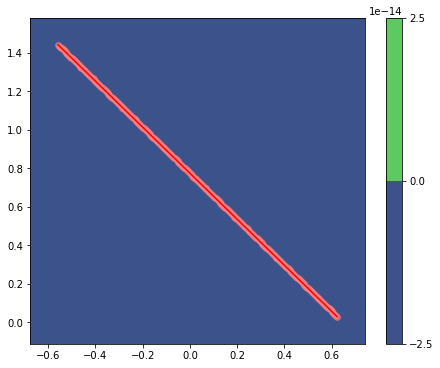

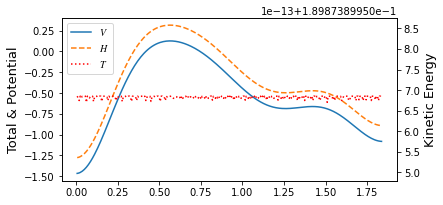

In [5]:
from taps.visualize import view
view(paths)

It showed something, but Since MB potential is exponentially increase outside its boundary, automatic resizeing or map leveling doesn't help to understand its view. In order to visuallize correctly you need to manipulate all the parameters involing `plotter`. Fortunately, in this example, we will use pre-defined parameter set that set to focus on important properties. By just typing keyword `viewer`. 

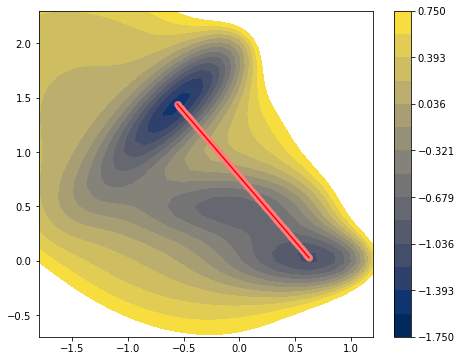

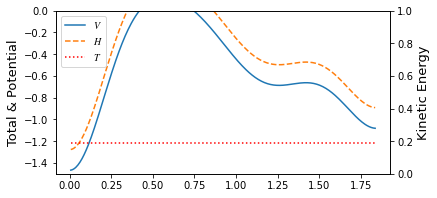

In [6]:
view(paths, viewer='MullerBrown')

Manipulating the `Cartesian` can be done by manually change the number of the `coords` array. However, manipulating the pathway manually is very diffcult process than changing just a coordinate of some atomic system. If one wants to test a random pathway rather than a liner pathway, one can fluctuate the pathway by adjusting sine components of the `coords`. TAPS has built in fluctuation function that do just that. You can type 
```python
paths.fluctuate()
```
and it will randomize its pathway. Keyword `fluctuation` adjust the amplitutde of its fluctuation. 

In [7]:
paths.fluctuate(fluctuation=1)

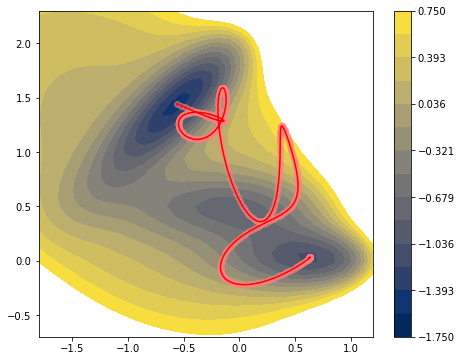

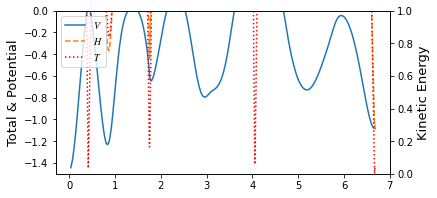

In [8]:
view(paths, viewer='MullerBrown')

Randomizing a pathway not only gives you more pleasing look but also make a pathway more unbiased. It can test pathway optimization algorithm working in any pathway in a simpler manner.  

## Direct Action Optimization

`PathFinder` classs perfoms pathway optimization. Here we use direct action optimization method (DAO) to minimize the action of the pathway. `DAO` optimizes the pathway by lowering the value of its action using `scipy`'s `minimize` package. All together, this requires parameters needed for the `DAO` and parameters for `scipy`. 

Parameters required for `DAO`, you can type "?"
```python
from taps.pathfinder import DAO
?DAO
```

In [9]:
from taps.pathfinder import DAO
?DAO

Init signature:
DAO(
    action_kwargs=None,
    search_kwargs=None,
    use_grad=True,
    logfile=None,
    **kwargs,
)
Docstring:     
Direct action optimizer (DAO)

Parameters
----------

use_grad: bool , default True
    Whether to use graidnet form of the action.

search_kwargs: Dict,
    Optimization keyword for scipy.minimize

action_kwargs: Dict of dict,
    {'Onsager Machlup': {'gamma': 2},
    'Total Energy restraint': ... }
File:           ~/anaconda3/envs/py37/lib/python3.7/site-packages/taps/pathfinder/dao.py
Type:           type
Subclasses:     TAO


We set target energy -0.45, muE 1. , tol 5e-2, gam 1. with Onsager Machlup action and energy conservation. Onsager Machlup action

$$ S_\mathrm{OM} = \frac{\Delta V}{2} + \frac{1}{4} \sum_{n=0}^{N}\left[\frac{dt}{2\gamma}\left(\left|\nabla V\left( \mathbf{x}^{\left(n+1\right)} \right)\right|^2+\left|\nabla V\left( \mathbf{x}^{\left(n\right)} \right)\right|^2\right) - \left(\nabla V\left( \mathbf{x}^{\left(n+1\right)} \right) - \nabla V \left( \mathbf{x}^{\left(n\right)} \right)\right) \cdot  \mathbf{v}^{\left(n\right)}+\frac{\gamma}{dt}\mathbf{v}^{\left(n\right)\mathbf{T}} \cdot \mathbf{v}^{\left(n\right)} \right] $$

with additional energy conservation restraint

$$\Theta_\mathrm{OM}\left(\left\{\mathbf{X}_\ast\right\},E_\mathrm{t}\right)=S_\mathrm{OM}+\mu_\mathrm{E}\sum_{n=0}^{N-1}\left(E^{\left(n\right)}-E_\mathrm{t}\right)^2$$

In [10]:
from taps.pathfinder import DAO

action_kwargs = {
    'Onsager Machlup':{    
        'gam': 1.,
    },
    'Energy Restraint':{
        'muE': 1.,
        'Et': -0.45
    }
}

search_kwargs = {"method":"L-BFGS-B"}

finder = DAO(action_kwargs=action_kwargs,
             search_kwargs=search_kwargs)

paths.finder = finder
paths.coords.epoch=6
paths.search()

      DAO Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :  10900  11169  11169   1.8258   0.0093
Converge :  10904  11177  11177   1.8258   0.0067
Converge :  10906  11183  11183   1.8258   0.0014

            Results
 Onsager Machlup             : 1.25531330718968
 Energy Restraint            : 0.5704908468997049
 Total S                     : 1.825804154089385


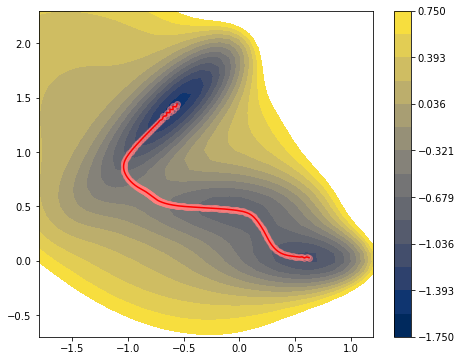

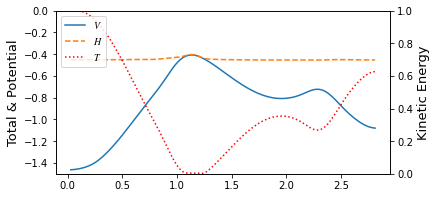

In [11]:
view(paths, viewer='MullerBrown')